# Basic Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
import torch
import math
import torch.nn as nn
import torch.optim as optim
from torch import sigmoid
from torch import tanh
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

Defining Device

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


**Hyperparameters**

In [3]:
lr = 0.003
epochs = 150
sequence_length = 5
input_length = 1
hidden_length = 20
output_size = 1
batch_size = 32

# Loading Dataset

In [4]:
data = pd.read_csv('/kaggle/input/air-passengers/AirPassengers.csv')
data.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


# Preprocessing and Visualizing Distribution

In [5]:
data['Month'] = pd.to_datetime(data['Month'])
data.head()

,Month,#Passengers
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


In [6]:
# Checking for any data duplicay

data.duplicated().sum()

0

In [7]:
# Handling missing values

data.dropna(inplace=True)

In [8]:
data.head()

,Month,#Passengers
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


In [9]:
data.isna().sum()

Month          0
#Passengers    0
dtype: int64

In [10]:
data.describe()

,Month,#Passengers
count,144,144.000000
mean,1954-12-16 05:00:00,280.298611
min,1949-01-01 00:00:00,104.000000
25%,1951-12-24 06:00:00,180.000000
50%,1954-12-16 12:00:00,265.500000
75%,1957-12-08 18:00:00,360.500000
max,1960-12-01 00:00:00,622.000000
std,NaN,119.966317


# Visualizations

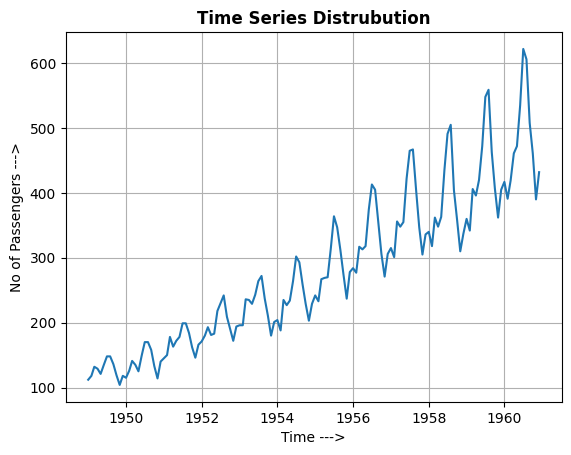

In [11]:
plt.plot(data['Month'], data['#Passengers'])
plt.title("Time Series Distrubution", weight='bold')
plt.ylabel('No of Passengers --->')
plt.xlabel('Time --->')
plt.grid(True)
plt.show()

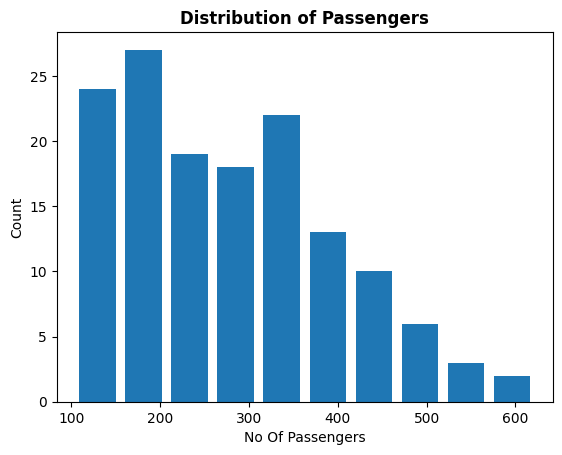

In [12]:
plt.hist(data['#Passengers'], bins=10, rwidth=0.8)
plt.title('Distribution of Passengers', weight='bold')
plt.ylabel('Count')
plt.xlabel('No Of Passengers')
plt.show()

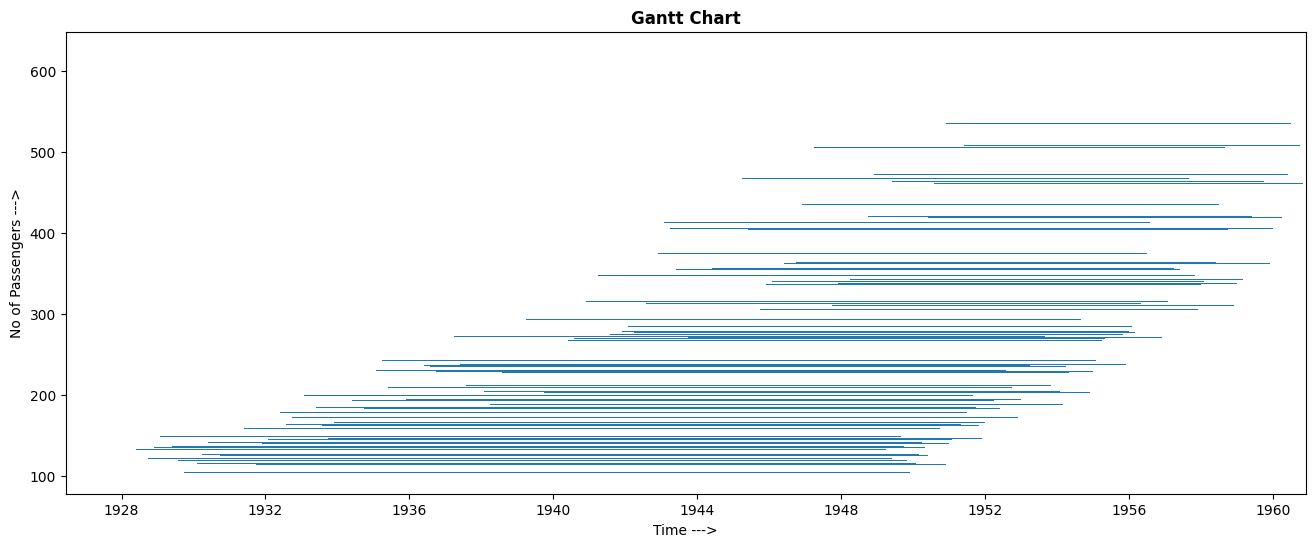

In [13]:
fig, ax = plt.subplots(1, figsize=(16,6))
ax.barh(data['#Passengers'], data['Month'], left=data['Month'].shift(-1), height=0.8)
plt.title('Gantt Chart', weight = 'bold')
plt.xlabel('Time --->')
plt.ylabel('No of Passengers --->')
plt.show()

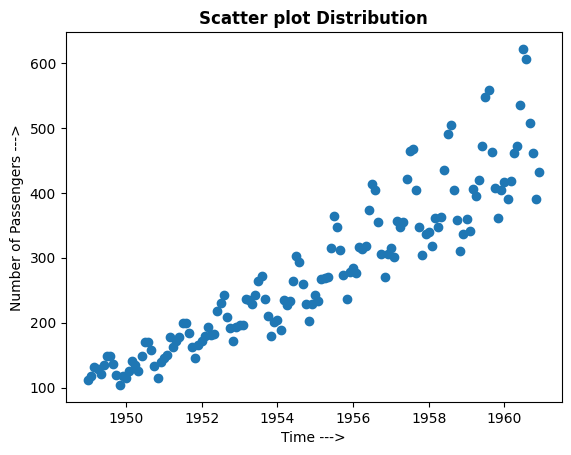

In [14]:
plt.scatter(data['Month'], data['#Passengers'])
plt.title('Scatter plot Distribution', weight='bold')
plt.xlabel('Time --->')
plt.ylabel('Number of Passengers --->')
plt.show()

**Seasonal Decomposition**

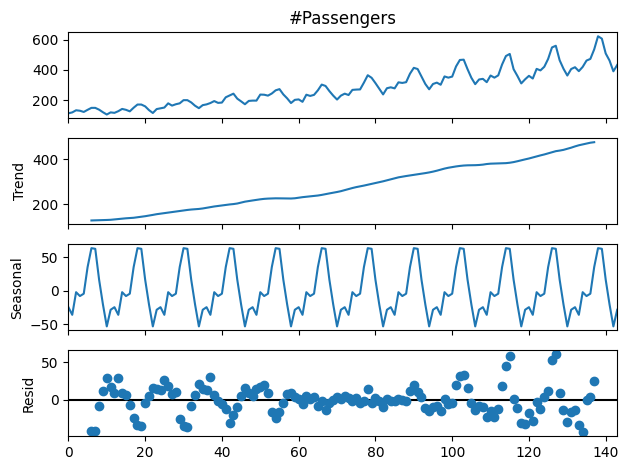

In [15]:
result = seasonal_decompose(data['#Passengers'], model='additive', period=12)
result.plot()
plt.show()

# Implementing LSTM from Scratch

In [16]:
class LSTM(nn.Module):
    def __init__(self, input_length, hidden_length, a1 = sigmoid, a2 = tanh):
        super(LSTM, self).__init__()
        self.input_length = input_length
        self.hidden_length = hidden_length
        self.a1 = a1
        self.a2 = a2

        # Forget State Parameters
        self.W_i_f = nn.Parameter(torch.Tensor(input_length, hidden_length))
        self.W_f_f = nn.Parameter(torch.Tensor(hidden_length, hidden_length))
        self.bf = nn.Parameter(torch.Tensor(hidden_length))

        # Input State Parameters
        self.W_i_i = nn.Parameter(torch.Tensor(input_length, hidden_length))
        self.W_f_i = nn.Parameter(torch.Tensor(hidden_length, hidden_length))
        self.bi = nn.Parameter(torch.Tensor(hidden_length))

        # Cell State Parameters
        self.W_i_c = nn.Parameter(torch.Tensor(input_length, hidden_length))
        self.W_f_c = nn.Parameter(torch.Tensor(hidden_length, hidden_length))
        self.bc = nn.Parameter(torch.Tensor(hidden_length))

        # Output Gate Parameters
        self.W_i_o = nn.Parameter(torch.Tensor(input_length, hidden_length))
        self.W_f_o = nn.Parameter(torch.Tensor(hidden_length, hidden_length))
        self.bo = nn.Parameter(torch.Tensor(hidden_length))

        self.init_weights()

    def init_weights(self):
        # Applying Xavier Weight Initialization U(-sqrt(6)/sqrt(input + output), sqrt(6)/sqrt(input + output))

        # Initializing weights and bias of LSTM using Xavier initialization
        for param in self.parameters():
            param.data.uniform_(-1 * math.sqrt((6)/(self.input_length + self.hidden_length)), 1 * math.sqrt((6)/(self.input_length + self.hidden_length)))

    def forward(self, x, h0=None, c0=None):
        # x tensor size = (batch_size, squence_length, input_length)

        sequence_length = x.shape[0]
        hidden_sequence = []

        # Initial States
        if h0 == None or c0 == None:
            h0 = torch.zeros(sequence_length, self.hidden_length).to(x.device)
            c0 = torch.zeros(sequence_length, self.hidden_length).to(x.device)

        xt = x

        # it = sigmoid(W_i_i * xt + W_f_i * ht-1 + bi)
        it = self.a1(xt @ self.W_i_i + h0 @ self.W_f_i + self.bi)

        # ft = sigmoid(W_i_t * xt + W_h_t * ht-1 + bf)
        ft = self.a1(xt @ self.W_i_f + h0 @ self.W_f_f + self.bf)

        gt = self.a2(xt @ self.W_i_c + h0 @ self.W_f_c + self.bc)

        # ot = sigmoid(W_i_o * xt + W_f_o * ht-1 + bo)
        ot = self.a1(xt @ self.W_i_o + h0 @ self.W_f_o + self.bo)

        # Ct = ft * Ct-1 + it * ct
        c0 = ft * c0 + it * gt
        h0 = ot * self.a2(c0)

        hidden_sequence.append(h0.unsqueeze(0))

        hidden_sequence = torch.cat(hidden_sequence, dim=0)
        hidden_sequence = hidden_sequence.transpose(0, 1).contiguous()
        return hidden_sequence, (h0, c0)

class Net(nn.Module):
    def __init__(self, input_length, hidden_length, output_size, a1 = sigmoid, a2 = tanh):
        super(Net, self).__init__()

        self.lstm = LSTM(input_length, hidden_length, a1, a2)
        self.fc = nn.Linear(hidden_length, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out)
        return out

In [17]:
lstm = Net(input_length, hidden_length, output_size).to(device)

In [18]:
input = torch.rand(sequence_length, input_length)
lstm(input.to(device))

tensor([[[0.0240]],

        [[0.0272]],

        [[0.0172]],

        [[0.0256]],

        [[0.0476]]], device='cuda:0', grad_fn=<ViewBackward0>)

Loss Function and Optimizer

In [19]:
criterion = nn.MSELoss()
optimizer = optim.Adam(lstm.parameters(), lr)

# Creating DataLoaders

In [20]:
class CustomDataset(Dataset):
    def __init__(self, data, seq_len):
        super(CustomDataset, self).__init__()
        self.seq_len = seq_len
        self.data = data
        self.inputs, self.outputs = [], []

        for i in range(len(data) - seq_len - 1):
            self.inputs.append(self.data['#Passengers'][i : i + self.seq_len].values)
            self.outputs.append(self.data['#Passengers'][i + 1: i + self.seq_len +1].values)

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, index):
        x = self.inputs[index]
        y = self.outputs[index]
        return (torch.tensor(x), torch.tensor(y))

In [21]:
dataset = CustomDataset(data, sequence_length)

In [22]:
def get_data_loaders(data, seq_len):
    dataset = CustomDataset(data, seq_len)

    # Splitting the Dataset into train, test, and validation dataset

    train_size = int(0.7 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, rest_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

    val_size = int(1/3 * len(rest_dataset))
    test_size = len(rest_dataset) - val_size
    val_dataset, test_dataset = torch.utils.data.random_split(rest_dataset, [val_size, test_size])

    return train_dataset, val_dataset, test_dataset

In [23]:
train_loader, val_loader, test_loader = get_data_loaders(data, sequence_length)

# Important Metrics

In [24]:
def get_val_loss(model, data):
    model.eval()
    with torch.no_grad():
        val_loss = 0.0
        for x, y in data:
            x = x.reshape(x.shape[0], 1).to(torch.float32).to(device)
            y = y.to(torch.float32).to(device)

            # Forward Pass
            scores = model(x)
            scores = scores.reshape(scores.shape[0])
            val_loss += criterion(scores, y)

    return val_loss.item() / len(data)

In [25]:
def get_metrics(model, data):
    model.eval()

    mse_loss = 0.0
    rmse_loss = 0.0
    mae_loss = 0.0
    with torch.no_grad():
        for x, y in data:
            x = x.reshape(x.shape[0], 1).to(torch.float32).to(device)
            y = y.to(torch.float32).to(device)

            # Forward Pass
            scores = model(x)
            scores = scores.reshape(scores.shape[0])

            mse_loss += mean_squared_error(scores.cpu().numpy(), y.cpu().numpy())
            rmse_loss += np.sqrt(mean_squared_error(scores.cpu().numpy(), y.cpu().numpy()))
            mae_loss += mean_absolute_error(scores.cpu().numpy(), y.cpu().numpy())

    return mse_loss/len(data), rmse_loss/len(data), mae_loss/len(data)

# Training Loop

In [26]:
def train_lstm(model, data, seq_len, epochs, lr, display=False):

    optimizer = optim.Adam(model.parameters(), lr)

    train_loader, val_loader, test_loader = get_data_loaders(data, seq_len)
    train_losses, validation_losses = [], []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for x, y in train_loader:
            x = x.reshape(x.shape[0], 1).to(torch.float32).to(device)
            y = y.to(torch.float32).to(device)

            # Resetting the gradients to zero
            optimizer.zero_grad()

            # Forward Pass
            scores = model(x)
            scores = scores.reshape(scores.shape[0])

            # Calculating Loss
            loss = criterion(scores, y)

            # Backward Propagation
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Calculating validation loss
        val_loss = get_val_loss(model, val_loader)
        train_losses.append(running_loss/len(train_loader))
        validation_losses.append(val_loss)
        if display:
            print(f"Epoch {epoch+1} | Training Loss =",running_loss/len(train_loader), "| Validation Loss =", val_loss)

    return model, train_losses, validation_losses

In [27]:
lstm, train_losses, validation_losses = train_lstm(lstm , data, sequence_length, epochs, lr, True)

Epoch 1 | Training Loss = 94812.71718343098 | Validation Loss = 83036.53571428571
Epoch 2 | Training Loss = 93402.85455322266 | Validation Loss = 81765.01785714286
Epoch 3 | Training Loss = 92096.18291219075 | Validation Loss = 80533.66964285714
Epoch 4 | Training Loss = 90819.77590942383 | Validation Loss = 79325.66071428571
Epoch 5 | Training Loss = 89564.79280598958 | Validation Loss = 78136.83928571429
Epoch 6 | Training Loss = 88328.38826497395 | Validation Loss = 76965.4375
Epoch 7 | Training Loss = 87109.16673787434 | Validation Loss = 75810.40178571429
Epoch 8 | Training Loss = 85906.27674357097 | Validation Loss = 74671.11607142857
Epoch 9 | Training Loss = 84719.11568196614 | Validation Loss = 73547.03571428571
Epoch 10 | Training Loss = 83547.2368774414 | Validation Loss = 72437.79464285714
Epoch 11 | Training Loss = 82390.25541178386 | Validation Loss = 71343.03571428571
Epoch 12 | Training Loss = 81247.85321044922 | Validation Loss = 70262.49553571429
Epoch 13 | Training L

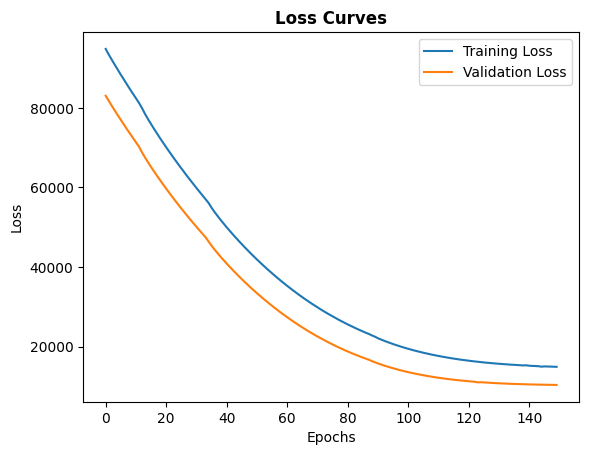

In [28]:
plt.plot(train_losses, label = 'Training Loss')
plt.plot(validation_losses, label = 'Validation Loss')
plt.title('Loss Curves', weight='bold')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [29]:
original_trend = data['#Passengers'].values
original_trend = torch.tensor(original_trend).to(torch.float32).to(device)
pred_trend = lstm(original_trend.reshape(original_trend.shape[0], 1))
pred_trend = pred_trend.reshape(pred_trend.shape[0]).cpu().detach().numpy()

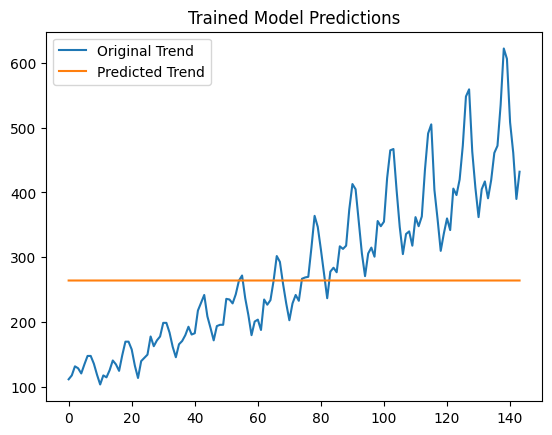

In [30]:
plt.plot(data['#Passengers'], label='Original Trend')
plt.plot(pred_trend, label='Predicted Trend')
plt.title('Trained Model Predictions')
plt.legend()
plt.show()

# Model Evaluation on Test Data

In [31]:
# MSE, RMSE, MAE Evaluation

mse_loss, rmse_loss, mae_loss = get_metrics(lstm, test_loader)

In [32]:
print("Mean Squared Error for Test Data =", mse_loss)
print("Root Mean Squared Error for Test Data =", rmse_loss)
print("Mean Absolute Error for Test Data =", mae_loss)

Mean Squared Error for Test Data = 17829.916769845146
Root Mean Squared Error for Test Data = 110.45589705875942
Mean Absolute Error for Test Data = 106.25056982040405


# Hyperparameters Tuning

In [33]:
max_epochs = [50, 100, 150]
lrs = [0.01, 0.02, 0.002]
seq_lengths = [5, 10, 12]

best_metric = 100000000000

best_epoch = 0
best_lr = 0
best_seq_length = 0

for epochs in max_epochs:
    for lr in lrs:
        for seq_len in seq_lengths:
            lstm = Net(input_length, hidden_length, output_size).to(device)
            lstm, train_losses, validation_losses = train_lstm(lstm , data, seq_len, epochs, lr)

            mse_loss, rmse_loss, mae_loss = get_metrics(lstm, test_loader)

            if mse_loss < best_metric:
                best_metric = mse_loss
                best_epoch = epochs
                best_lr = lr
                best_seq_length = seq_len

print("Best Number of Epochs =", best_epoch)
print("Best Learning Rate =", lr)
print("Best Sequence Length =", best_seq_length)

Best Number of Epochs = 150
Best Learning Rate = 0.002
Best Sequence Length = 10


In [34]:
best_model =  Net(input_length, hidden_length, output_size).to(device)
best_model, train_losses, validation_losses = train_lstm(best_model , data, best_seq_length, best_epoch, best_lr, True)

Epoch 1 | Training Loss = 87885.58033014114 | Validation Loss = 70119.22596153847
Epoch 2 | Training Loss = 82655.21479124665 | Validation Loss = 65503.11057692308
Epoch 3 | Training Loss = 77766.51099420364 | Validation Loss = 61177.89903846154
Epoch 4 | Training Loss = 73163.5044312836 | Validation Loss = 57115.581730769234
Epoch 5 | Training Loss = 68824.31221123152 | Validation Loss = 53300.35096153846
Epoch 6 | Training Loss = 64734.45168640793 | Validation Loss = 49719.57692307692
Epoch 7 | Training Loss = 60881.85083270329 | Validation Loss = 46362.13461538462
Epoch 8 | Training Loss = 57255.63986632645 | Validation Loss = 43217.682692307695
Epoch 9 | Training Loss = 53845.67926747312 | Validation Loss = 40276.463942307695
Epoch 10 | Training Loss = 50642.388208532844 | Validation Loss = 37529.20192307692
Epoch 11 | Training Loss = 47636.6283484018 | Validation Loss = 34966.995192307695
Epoch 12 | Training Loss = 44819.61782541583 | Validation Loss = 32581.23798076923
Epoch 13 |

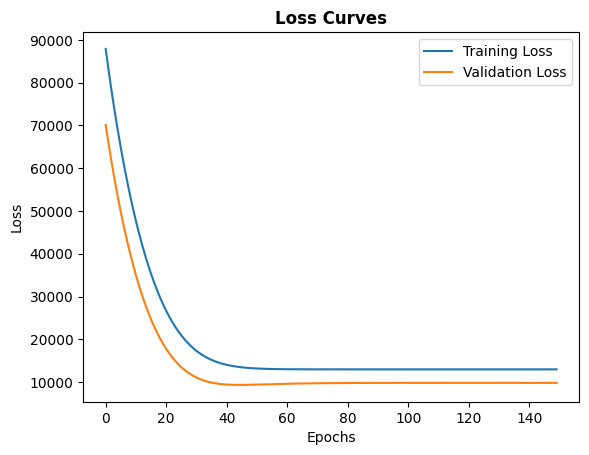

In [35]:
plt.plot(train_losses, label = 'Training Loss')
plt.plot(validation_losses, label = 'Validation Loss')
plt.title('Loss Curves', weight='bold')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Activation Function Comparision

Relu Activation

In [36]:
lstm = Net(input_length, hidden_length, output_size, a1=torch.relu).to(device)
lstm_relu, train_losses_relu, validation_losses_relu = train_lstm(lstm , data, seq_len, epochs, lr)

In [37]:
# MSE, RMSE, MAE Evaluation

mse_loss, rmse_loss, mae_loss = get_metrics(lstm_relu, test_loader)

In [38]:
print("Mean Squared Error for Test Data =", mse_loss)
print("Root Mean Squared Error for Test Data =", rmse_loss)
print("Mean Absolute Error for Test Data =", mae_loss)

Mean Squared Error for Test Data = 1038.496819632394
Root Mean Squared Error for Test Data = 28.059830563408987
Mean Absolute Error for Test Data = 23.603949308395386


tanh Activation

In [39]:
lstm = Net(input_length, hidden_length, output_size, a1=torch.tanh).to(device)
lstm_tanh, train_losses_tanh, validation_losses_tanh = train_lstm(lstm , data, seq_len, epochs, lr)

In [40]:
# MSE, RMSE, MAE Evaluation

mse_loss, rmse_loss, mae_loss = get_metrics(lstm_tanh, test_loader)

In [41]:
print("Mean Squared Error for Test Data =", mse_loss)
print("Root Mean Squared Error for Test Data =", rmse_loss)
print("Mean Absolute Error for Test Data =", mae_loss)

Mean Squared Error for Test Data = 18458.48091670445
Root Mean Squared Error for Test Data = 110.30075103896004
Mean Absolute Error for Test Data = 106.59149861335754


Loss Plots for Both Activation

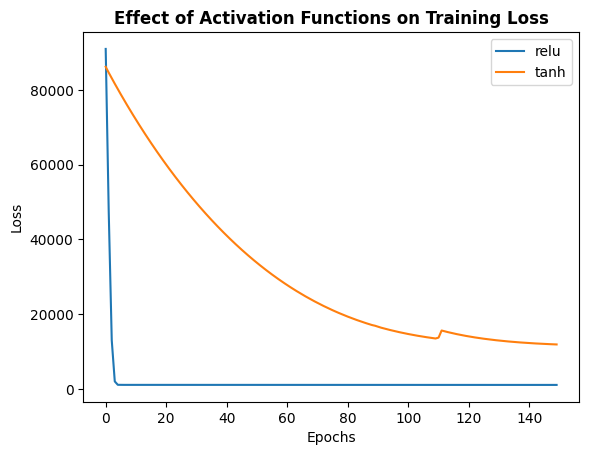

In [51]:
plt.plot(train_losses_relu, label='relu')
plt.plot(train_losses_tanh, label='tanh')
plt.title('Effect of Activation Functions on Training Loss', weight='bold')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Hidden Size Comparision

hidden_length = 30

In [43]:
lstm = Net(input_length, 30, output_size).to(device)
lstm_30, train_losses_30, validation_losses_30 = train_lstm(lstm , data, seq_len, epochs, lr)

In [44]:
# MSE, RMSE, MAE Evaluation

mse_loss, rmse_loss, mae_loss = get_metrics(lstm_30, test_loader)

In [45]:
print("Mean Squared Error for Test Data =", mse_loss)
print("Root Mean Squared Error for Test Data =", rmse_loss)
print("Mean Absolute Error for Test Data =", mae_loss)

Mean Squared Error for Test Data = 16725.755705697196
Root Mean Squared Error for Test Data = 89.12335079056876
Mean Absolute Error for Test Data = 85.3364964553288


hidden_length = 50

In [46]:
lstm = Net(input_length, 50, output_size).to(device)
lstm_50, train_losses_50, validation_losses_50 = train_lstm(lstm , data, seq_len, epochs, lr)

In [47]:
# MSE, RMSE, MAE Evaluation

mse_loss, rmse_loss, mae_loss = get_metrics(lstm_50, test_loader)

In [48]:
print("Mean Squared Error for Test Data =", mse_loss)
print("Root Mean Squared Error for Test Data =", rmse_loss)
print("Mean Absolute Error for Test Data =", mae_loss)

Mean Squared Error for Test Data = 14397.932180677142
Root Mean Squared Error for Test Data = 87.94328883716038
Mean Absolute Error for Test Data = 84.20753141811916


Loss Plots for both Hidden Length

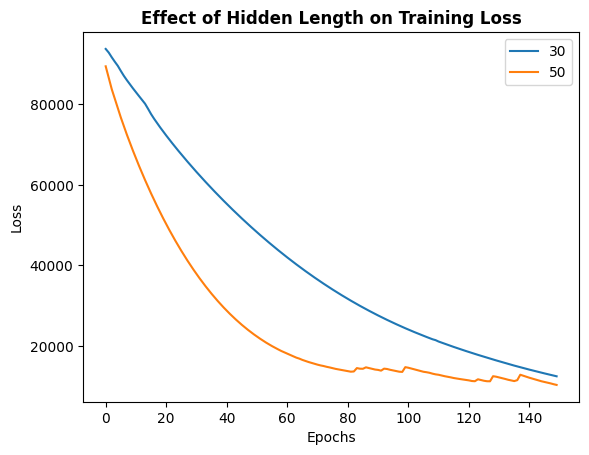

In [49]:
plt.plot(train_losses_30, label='30')
plt.plot(train_losses_50, label='50')
plt.title('Effect of Hidden Length on Training Loss', weight='bold')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()